In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import logging
import time
# mu_0, alpha_0


In [47]:
'''
inputs s: (2n,1), a: (n,1)
output: Plot of aircrafts and the directions using an arrow
'''

def visualize_state(s,a,ax):
  ax.plot([14,16],[15,15],'k-',linewidth=5,label='Active Runway')
  ax.set_xticks(np.linspace(1,30,30))
  ax.set_yticks(np.linspace(1,30,30))
  ax.set_xlim(0,31)
  ax.set_ylim(0,31)
  ax.grid(which='both')
  u=[1,1,0,-1,-1,-1,0,1]
  v=[0,1,1,1,0,-1,-1,-1]
  for i in range(int(s.shape[0]/2)):
      ax.plot([s[2*i]],[s[2*i+1]],'o',markersize=10,label=str(i))
      ax.quiver([s[2*i]],[s[2*i+1]],[u[a[i]-1]],[v[a[i]-1]],width=0.003)
  ax.legend()

def visualize_with_utility(s,a,ax,u_model):
  ax.plot([14,16],[15,15],'k-',linewidth=5,label='Active Runway')
  ax.set_xticks(np.linspace(1,30,30))
  ax.set_yticks(np.linspace(1,30,30))
  ax.set_xlim(0,31)
  ax.set_ylim(0,31)
  ax.grid(which='both')
  u=[1,1,0,-1,-1,-1,0,1]
  v=[0,1,1,1,0,-1,-1,-1]
  xs=np.linspace(0,31,32)
  ys=np.linspace(0,31,32)
  x_grid,y_grid=np.meshgrid(xs,ys)
  z=np.zeros_like(x_grid)
  for i in range(32):
    for j in range(32):
      x=x_grid[i,j]
      y=y_grid[i,j]
      z[i,j]=u_model.predict(np.array([[x,y]]),verbose=False)[0,0]
  for i in range(int(s.shape[0]/2)):
      ax.plot([s[2*i]],[s[2*i+1]],'o',markersize=10,label=str(i))
      ax.quiver([s[2*i]],[s[2*i+1]],[u[a[i,0]-1]],[v[a[i,0]-1]],width=0.003)
  print(z.shape)
  plt.contourf(x_grid,y_grid,z)
  ax.legend()
  plt.colorbar(ax=ax)


In [48]:
''' Set up State matrix, action matrix at random
input: num_states and num_aircrafts
output: s 2*n X 2*num_aircrafts

'''
def initialize(num_states=1,num_aircrafts = 3):
  s = np.random.randint(1,31,size = (2*num_aircrafts,num_states)).T
  return s

print(initialize(5,3))



[[22 18 16  5  4 19]
 [22 12 11  5  3  4]
 [20  7 17  1  1 11]
 [ 8 15 19 11  4 18]
 [19 27  6  2 13  1]]


In [49]:
'''
input: s 2*n X 1
output: Bool
'''
def out_of_bounds(s):
  return np.sum((s>30).any() or (s<1).any())
# def landing(s,runway):
#   n = int(s.shape[0]/2)
#   return np.sum(s.reshape(n,2)==runway)/2
'''
input: s 2*n X 1 , goal 2 X 1
output: Float
'''

def reward(s,goal = np.array([[15,15]]).T):
  Points = {}
  reward = 0
  n = int(s.shape[0]/2)
  for i in range(n):
    Points[i+1] = s[2*i:2*i+1]
    d = np.linalg.norm(goal -Points[i+1])
    spread = 3
    if(d==0):
      reward+=100
    elif(d<8):
      reward+= 100*np.exp(-d/spread)
  reward -= out_of_bounds(s)*100

  for i in range(n):
    for j in range(1,n-i):
      if((Points[i+1]==goal).all() or (Points[j+1]==goal).all()):
        continue
      dist = np.linalg.norm(Points[i+1]-Points[j+1])
      reward += 0 if dist>4 else -100*np.exp(-dist/4)
  return reward


reward(np.array([[15,15,13,15,30,40]]).T)



-61.04679147497828

In [50]:
'''
input: arrays of states and actions
output: dictionary of non-zero transition probabilities

TODO:
Runway landings and boundary
'''
import itertools

def next_states(si,theta):
  return si + np.array([[np.sign(0 if abs(np.cos(np.radians(theta)))<0.01 else np.cos(np.radians(theta))),np.sign(0 if abs(np.sin(np.radians(theta)))<0.01 else np.sin(np.radians(theta)))]]).T

def Transition(s,a):
  goal = np.array([[15,15]]).T
  Points = {}
  actions = {}
  direction_list = []
  probability_list = []
  T = {}
  n = int(s.shape[0]/2)
  for i in range(n):
    Points[i+1] = s[2*i:2*i+1,:]
    ai = a[i:i+1]
    theta = int((ai-1)/8*360)
    theta_l = int((ai-1)/8*360) + 45
    theta_r = int((ai-1)/8*360) - 45
    probability_list.append([0.8,0.1,0.1])
    direction_list.append([theta,theta_l,theta_r])

  direction_combos = list(itertools.product(*direction_list))
  probability_list = list(itertools.product(*probability_list))

  t = {}

  for idx,ds in enumerate(direction_combos):
    p = 1
    tup = []
    for i in range(n):
      if((Points[i+1]==goal).all()):
        t[i+1] = goal
        p = p*probability_list[idx][i]
      else:
        t[i+1] = next_states(Points[i+1],ds[i])
        p = p*probability_list[idx][i]
        if(out_of_bounds(t[i+1])):
          t[i+1] = np.array([[-1,-1]]).T

      tup.append(t[i+1][0,0])
      tup.append(t[i+1][1,0])
    if tuple(tup) in T.keys():
      #print('dup')
      T[tuple(tup)] +=p
    else:
      T[tuple(tup)]  =  p

  norm =1.0/sum(list(T.values()))
  for key in T:
    T[key] = T[key]*norm
  return T


T = Transition(np.array([[15,15,15,15,15,15]]).T,np.array([[1,2,5]]).T)
print(T)



{(15, 15, 15, 15, 15, 15): 1.0}


In [51]:
'''
input: Tradition Matrix Dict
output: Random Next State and Value
'''

def random_next(T):
  pick_list = len(T)
  k = list(T.keys())
  v = list(T.values())
  # choice = np.random.choice(np.array(range(pick_list)), p = np.array(v))
  choice = np.where(np.random.multinomial(1,v))[0][0]
  return np.array(k[choice]).reshape((-1,1)), reward(np.array(k[choice]).reshape((-1,1)))


In [52]:
'''
input: state 2*n X 1
output: Random Policy nX1
'''
def random_policy(s):
  n=int(s.shape[0]/2)
  return np.random.randint(1,9,size=(n,1))
random_policy(np.array([1,1,1,1,1,1]))

array([[5],
       [1],
       [3]])

In [53]:
print(initialize().shape)

'''
input: state 2*n X 1
output: Random Policy nX1
'''
def simulate(s0,k,policy,discount=0.9):
  rewards=0
  states=np.zeros((k,s0.shape[0]))
  states[0,:]=s0.reshape((-1,))
  actions=np.zeros((k-1,3))
  for i in range(k-1):
    s=states[i,:].reshape((-1,1))
    a=policy(s)
    T=Transition(s,a)
    s_next,r=random_next(T)
    rewards+=r
    states[i+1,:]=s_next.reshape((-1,))
    actions[i,:]=a.reshape((-1,))
  return states,actions,rewards

(1, 6)


In [54]:
policy = random_policy
k = 3
s0 = initialize().T
simulate(s0,k,policy,discount=0.9)

(array([[22., 16., 29., 25., 29., 24.],
        [23., 22., 28., 30., 28., 29.],
        [22., 24., 29., 28., 27., 29.]]),
 array([[1., 4., 5.],
        [4., 1., 5.]]),
 -200.0)

#Neural Network

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


class ValueApproximationNN():

  def __init__(self,num_aircrafts,hidden_layers=3,hidden_layer_dims = 8, optim = 'adam',tolerance = 1e-4):
    self.state_size = 2*num_aircrafts
    self.batch_size = 50
    self.value_dim = 1
    self.model = Sequential()
    self.Train_Flag = False
    self.callback = EarlyStopping(monitor="loss",min_delta=tolerance)
    self.model.add(Dense(hidden_layer_dims, input_dim=self.state_size, activation='sigmoid'))
    for i in range(hidden_layers-1):
      self.model.add(Dense(hidden_layer_dims, input_dim=hidden_layer_dims, activation='sigmoid'))
    self.model.add(Dense(self.value_dim, input_dim=hidden_layer_dims, activation='linear'))
    self.model.compile(loss='mean_squared_error', optimizer=optim, metrics=['mean_squared_error'])
    self.model.summary()

  def fit(self,X,Y, epochs = 10):
    self.history = self.model.fit(X, Y, epochs = epochs, batch_size=self.batch_size,callbacks=[self.callback],verbose=False)

  def predict(self,State):
    op = self.model.predict(np.array(State),verbose=False)
    return op.reshape((-1,1))





In [56]:
X = np.array([[1,2,4,2,4,2],[8,2,4,15,14,12],[1,23,19,12,4,12],[24,9,5,13,14,27]])
U = np.array([[24,90,22,45]]).T

NN = ValueApproximationNN(3)
NN.fit(X,U)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 56        
                                                                 
 dense_21 (Dense)            (None, 8)                 72        
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 209 (836.00 Byte)
Trainable params: 209 (836.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
NN.predict(np.array([[13,12,14,22,4,9],[23,52,14,22,4,9]]))

array([[1.177782],
       [1.13123 ]], dtype=float32)

In [58]:
'''
input: state 2*n X 1
'''
class ApproximateValueIteration():
  def __init__(self, model_type=ValueApproximationNN,discount=0.7,num_aircraft=1):
    self.model=model_type(num_aircraft)
    self.discount=discount
    self.num_aircraft = num_aircraft

  def run_iteration(self,k_max,num_S=100,epoch=100):
    for k in range(k_max):
      print(k)
      S=initialize(num_S,self.num_aircraft)
      U_new=self.backup(S)
      self.model.fit(S,U_new.reshape((-1,1)),epoch)

  def backup(self,S):
    n=int(S.shape[1]/2)
    U_new=np.zeros((S.shape[0],1))
    for i in range(S.shape[0]):
      best_val=-np.Inf
      action_list = [list(range(1,9)) for i in range(n)]  # Check Brackets
      action_combos = itertools.product(*action_list)
      for a in action_combos:
          a=np.array(a).reshape(-1,1)
          T=Transition(S[i:i+1,:].T,a)# Ched Dims
          val=0
          for next_state in T:
            val+=T[next_state]*self.model.predict(np.array(next_state).reshape((-1,1)).T)
          if val>best_val:
            best_val=val
      U_new[i,0]=reward(S[i,:])+self.discount*best_val
      return U_new

In [59]:
value_approximator=ApproximateValueIteration()
value_approximator.run_iteration(1000,100,100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8)                 24        
                                                                 
 dense_25 (Dense)            (None, 8)                 72        
                                                                 
 dense_26 (Dense)            (None, 8)                 72        
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 177 (708.00 Byte)
Trainable params: 177 (708.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52

In [60]:
UtilityFunction  = value_approximator.model.model

In [61]:
from keras.models import model_from_json
model_json = UtilityFunction.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
UtilityFunction.save_weights("model.h5")

In [62]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [63]:
def value_policy(s,u_model):
  n=int(s.shape[0]/2)
  action_list = [list(range(1,9)) for i in range(n)]  # Check Brackets
  action_combos = itertools.product(*action_list)
  best_val=-np.Inf
  best_action=np.ones((n,1))
  for a in action_combos:
    a=np.array(a).reshape(-1,1)
    T=Transition(s,a)# Ched Dims
    val=0
    for next_state in T:
      val+=T[next_state]*u_model.predict(np.array(next_state).reshape((-1,1)).T,verbose=False)
    if val>best_val:
      best_val=val
      best_action=a
  return a


[[8]]
(32, 32)


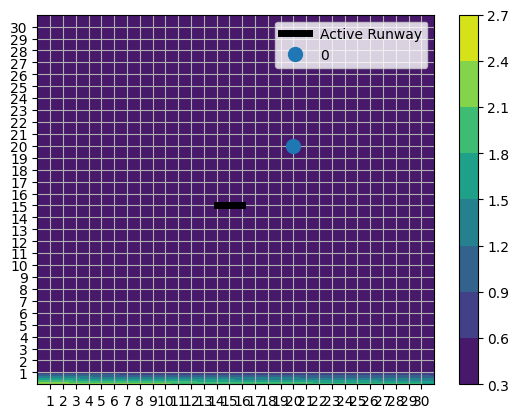

In [64]:
fig, ax = plt.subplots()
s=np.array([[20,20]]).T
print(value_policy(s,loaded_model))
visualize_with_utility(s,value_policy(s,loaded_model),ax,loaded_model)